In [1]:
!pip install -q scipy matplotlib
import torch_kan, torch
import matplotlib.pyplot as plt

from torch import nn


# class BatchedBSplines(nn.Module):
#     """
#     Batched B-Splines module for evaluating B-spline interpolation on batches of data.

#     Args:
#       inDim (int): Number of control points
#       k (int): Degree of B-spline.

#     Attributes:
#       t (torch.Tensor): Padded x-axis knots (inDim+2*k, ).
#     """

#     def __init__(self, inDim: int, k: int):
#         super().__init__()
#         if not isinstance(k, int):
#             raise ValueError(
#                 f"The degree k of B-spline must be an integer. Current : {k}"
#             )
#         self.k = k
#         if not isinstance(inDim, int):
#             raise ValueError(
#                 f"The number of control points (inDim) must be an integer. Current : {inDim}"
#             )
#         self.m = inDim - 1
#         self.t = torch.arange(-self.k, self.m + self.k) / (self.m - 1)

#     def forward(self, x: torch.Tensor, cp: torch.Tensor) -> torch.Tensor:
#         """
#         Forward pass method to compute batched B-spline interpolation.

#         Args:
#             x (torch.Tensor): Input tensor of shape (*, inDim, nEval).
#             cp (torch.Tensor): Control points tensor of shape (*, inDim, outDim, nCpts).

#         Returns:
#             torch.Tensor: Evaluated B-spline interpolation of shape (*, inDim, outDim, nEval).
#         """
#         assert (
#             cp.size(-1) == self.m + 1
#         ), "Control points must have m+1 element in the last dimension"

#         # Pads the control points with k-1 last elements -> (*, inDim, outDim, nCpts + k-1)
#         paddedCp = torch.cat(
#             [cp, cp[..., -1:].expand(*((cp.ndim - 1) * [-1]), self.k - 1)], dim=-1
#         )
#         # Gets the bin indices that contains x -> (*, inDim, nEval)
#         leftRange = (self.t.unsqueeze(-2) > x.clamp(0, 1).unsqueeze(-1)).float().argmax(
#             -1
#         ) - 1
#         # Create batched indices slices : B times a corresponding slice(m-k, m+1) -> (*, inDim, nEval, k)
#         slicesIndices = leftRange.unsqueeze(-1) + torch.arange(-self.k, 1).unsqueeze(-2)
#         # Duplicate indices along outDim -> (*, inDim,outDim, nEval, k)
#         slicesIndices = slicesIndices.unsqueeze(-3).expand(
#             *((len(slicesIndices.shape[:-2]) * [-1]) + [paddedCp.size(-2), -1, -1])
#         )
#         # Retrieve from control points all the batched slices -> (*, inDim,outDim, nEval, k)
#         d = paddedCp.gather(-1, slicesIndices.flatten(-2)).unflatten(
#             -1, (slicesIndices.shape[-2:])
#         )
#         # Proceed to optimized batched de Boor algorithm
#         for r in range(1, self.k + 1):
#             for j in range(self.k, r - 1, -1):
#                 alphas = (
#                     (x - self.t[j + leftRange - self.k])
#                     / (self.t[j + 1 + leftRange - r] - self.t[j + leftRange - self.k])
#                 ).unsqueeze(-2)
#                 d[..., j] = (1.0 - alphas) * d[..., j - 1] + alphas * d[..., j]
#         return d[..., self.k]


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# # B Splines parameters
# nEval = 16
# nCps = 8
# inDim, outDim = 5, 9
# k = 2
# # Note that B-Splines are estimated for inDim regular control points inside [0,1]

# xr = torch.linspace(0, 1, nEval).unsqueeze(0).expand(inDim, -1)
# cp = torch.rand(inDim, outDim, nCps)

# # # Note that B-Splines are estimated for inDim regular control points inside [0,1]
# splines = BatchedBSplines(nCps, k)
# ans = splines(xr, cp)

# i = 4
# j = 1
# plt.plot(xr[i], ans[i, j], "r-", lw=4, alpha=0.5, label="de Boor")
# plt.plot(
#     xr[0],
#     BSpline(splines.t.numpy(), cp[i, j], k)(
#         xr[i]
#     ),  # We check that the generated B-splines are correct with scipy implementation
#     "b-",
#     lw=4,
#     alpha=0.5,
#     label="GT BSpline",
# )
# plt.scatter(splines.t[k:-k], cp[i, 0, :-1])
# plt.legend(loc="best")
# plt.show()

In [3]:
from torch import nn


class KANLayer(nn.Module):
    CPS_INIT_STD = 0.1

    def __init__(self, inDim, outDim, k, nCps):
        super(KANLayer, self).__init__()

        self.nCps = nCps
        self.silu = nn.SiLU()
        self.splines = torch_kan.BatchedBSplines(self.nCps, k)
        self.cps = nn.Parameter(
            (torch.randn(inDim, outDim, self.nCps) * self.CPS_INIT_STD)
        )
        self.w = nn.Parameter(
            torch.randn(2, inDim, outDim, 1) * (2 / (inDim * outDim)) ** 0.5
        )

    def forward(self, x):
        # x : (B, inDim)
        return (
            (
                self.w[0] * self.splines(x.unsqueeze(-1), self.cps)
                + self.w[1] * self.silu(x).unsqueeze(-1).unsqueeze(-1)
            )
            .sum(-3)
            .squeeze(-1)
        )

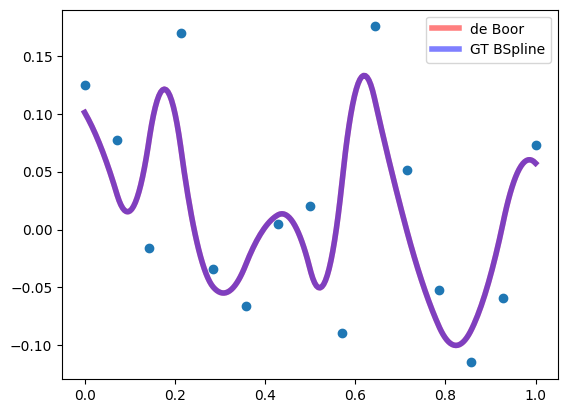

In [4]:
B = 15
k = 2
nEval = 250
inDim, outDim = 5, 9
kan = KANLayer(inDim, outDim, k)
x = torch.linspace(0, 1, nEval).unsqueeze(0).unsqueeze(0).expand(B, inDim, -1)
spl = kan.splines(x, kan.cps)


def plotSpline(splines, b, inDim, i, j):
    from scipy.interpolate import BSpline

    plt.plot(
        x[b, inDim].detach(),
        splines[b, i, j].detach(),
        "r-",
        lw=4,
        alpha=0.5,
        label="de Boor",
    )
    plt.plot(
        x[b, inDim],
        BSpline(kan.splines.t.detach(), kan.cps[i, j].detach(), k)(
            x[b, inDim]
        ),  # We check that the generated B-splines are correct with scipy implementation
        "b-",
        lw=4,
        alpha=0.5,
        label="GT BSpline",
    )
    plt.scatter(kan.splines.t[k:-k], kan.cps[i, j, :-1].detach())
    plt.legend(loc="best")
    plt.show()


plotSpline(spl, 0, 0, 1, 2)